## Preferential Bayesian optimization: PES and DTS comparison

In this notebook, we compare the PBO-PES formulation by Nguyen Quoc Phong to the PBO-DTS formulation by Gonzalez et al (2017).

The experiment consists of minimizing a latent objective function (Forrester function) with Bayesian optimization, where the queries are in the form of ordinal data, i.e. pairwise comparisons of point values. The aim is to minimize the difference between the model's best guess of the function minimizer and the actual minimizer (best guess error).

We conduct 20 runs, where each run has 10 initializing queries, and a further 20 queries to the objective function. We then average the model's best guess error after each query.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [2]:
def forrester(x):
    """
    1-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    :param x: float in domain [0, 1]
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)

In [3]:
def plot_avg_error(avg_error, title):
    x_axis = list(range(11, 31))
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(x_axis, avg_error)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess error', fontsize=16)
    plt.title(title)
    plt.show()

In [4]:
def plot_errors(errors, labels, title):
    x_axis = list(range(11, 31))
    plt.figure(figsize=(12, 6), dpi=200)
    for i in range(len(errors)):
        plt.plot(x_axis, errors[i], label=labels[i])
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess error', fontsize=16)
    plt.title(title)
    plt.legend()
    plt.show()

In [8]:
num_discrete_points = 1000000 # Discretization of continuous input space

In [9]:
xx = np.linspace(0.0, 1.0, num_discrete_points).reshape(num_discrete_points, 1)
global_min = xx[np.argmin(forrester(xx))][0]

In [10]:
global_min

0.7572487572487572

In [11]:
forrester(global_min)

-6.0207400557670825

### Dueling-Thompson sampling (baseline)

In [7]:
dts_X_results, dts_y_results, dts_best_guess_results = pickle.load( open( "results/PBO_DTS_results.p", "rb" ) )

In [8]:
dts_error = abs(dts_best_guess_results - global_min)

In [9]:
dts_avg_error = np.mean(dts_error, axis=0)

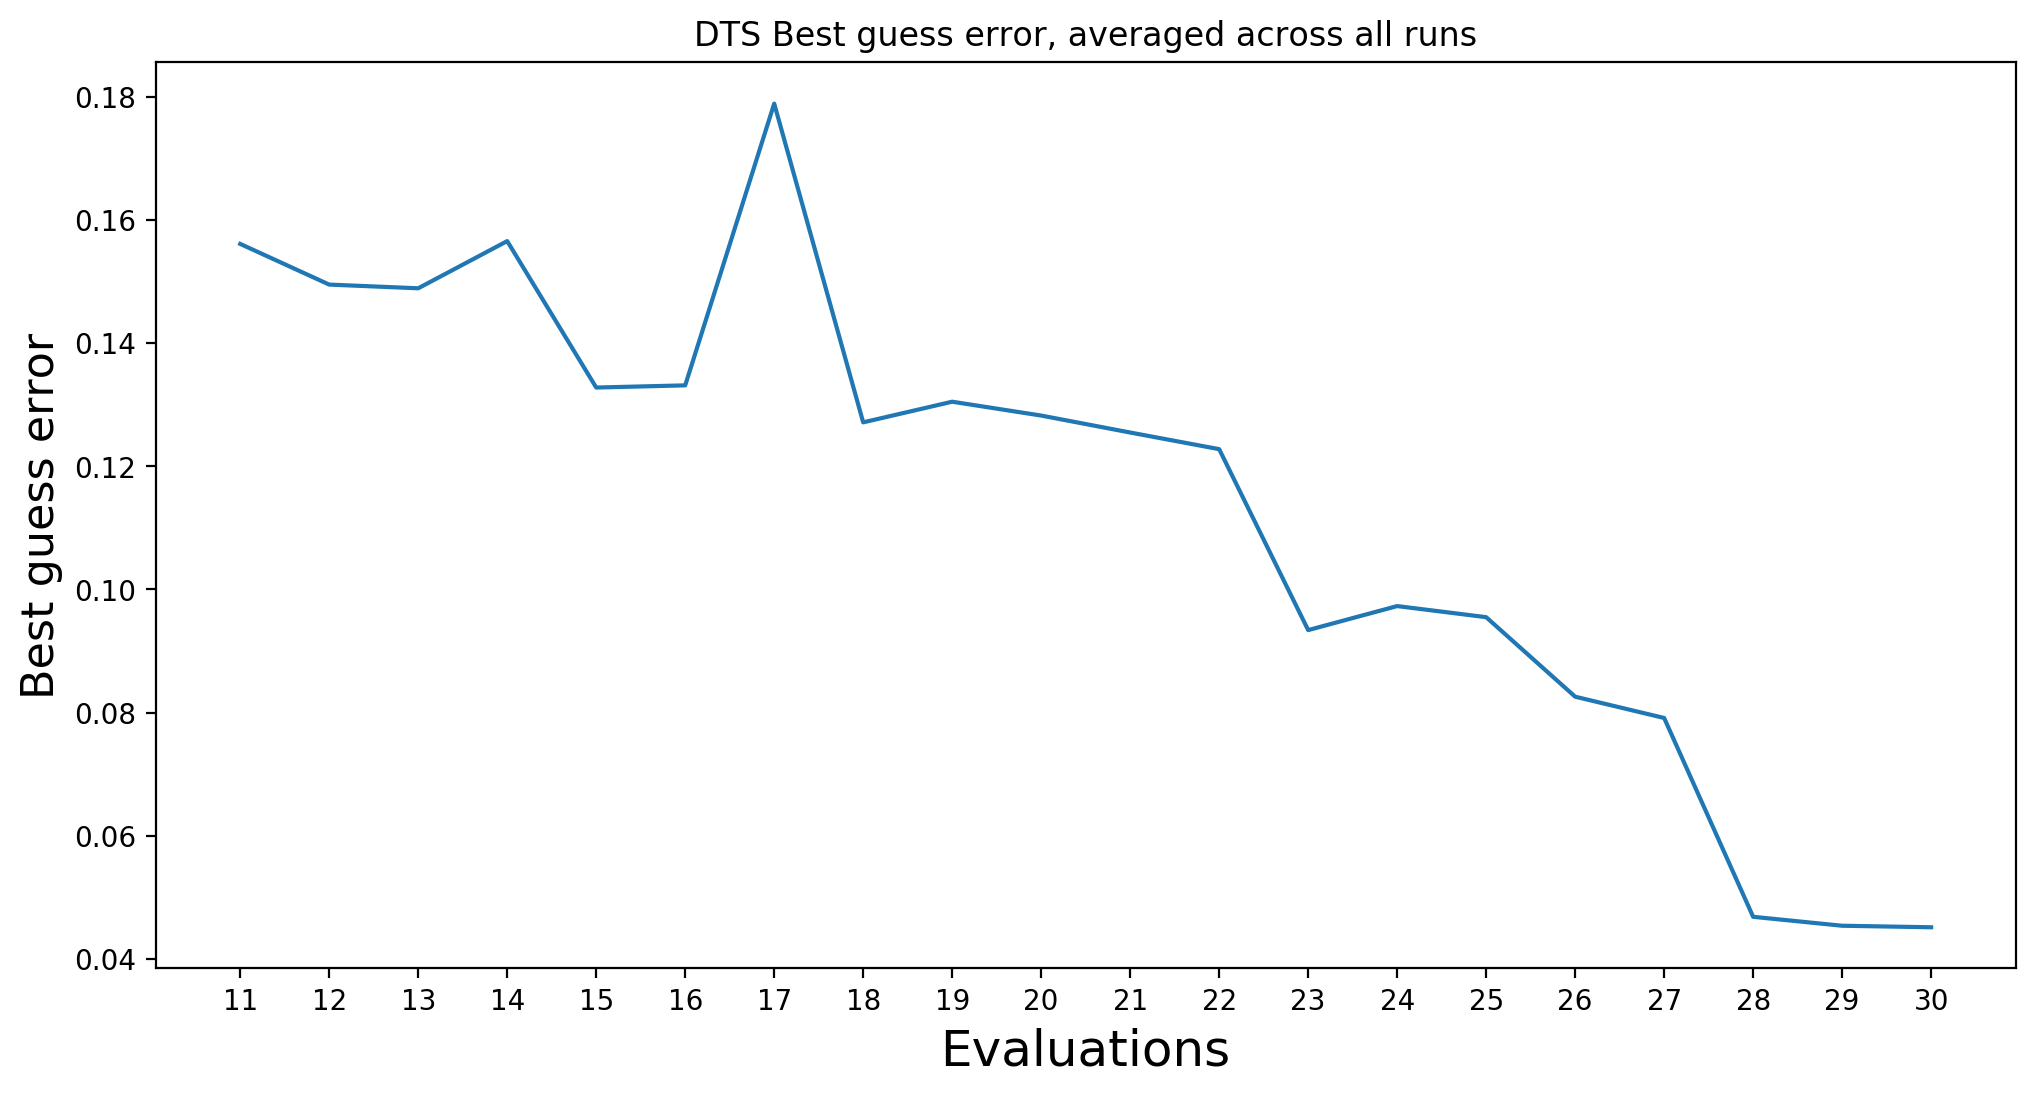

In [46]:
plot_avg_error(dts_avg_error, "DTS Best guess error, averaged across all runs")

In [11]:
print("DTS absolute best guess error after 30 evaluations: {}".format(dts_avg_error[19]))

DTS absolute best guess error after 30 evaluations: 0.04515807436599518


Sample of visualizations of models at final evaluation:

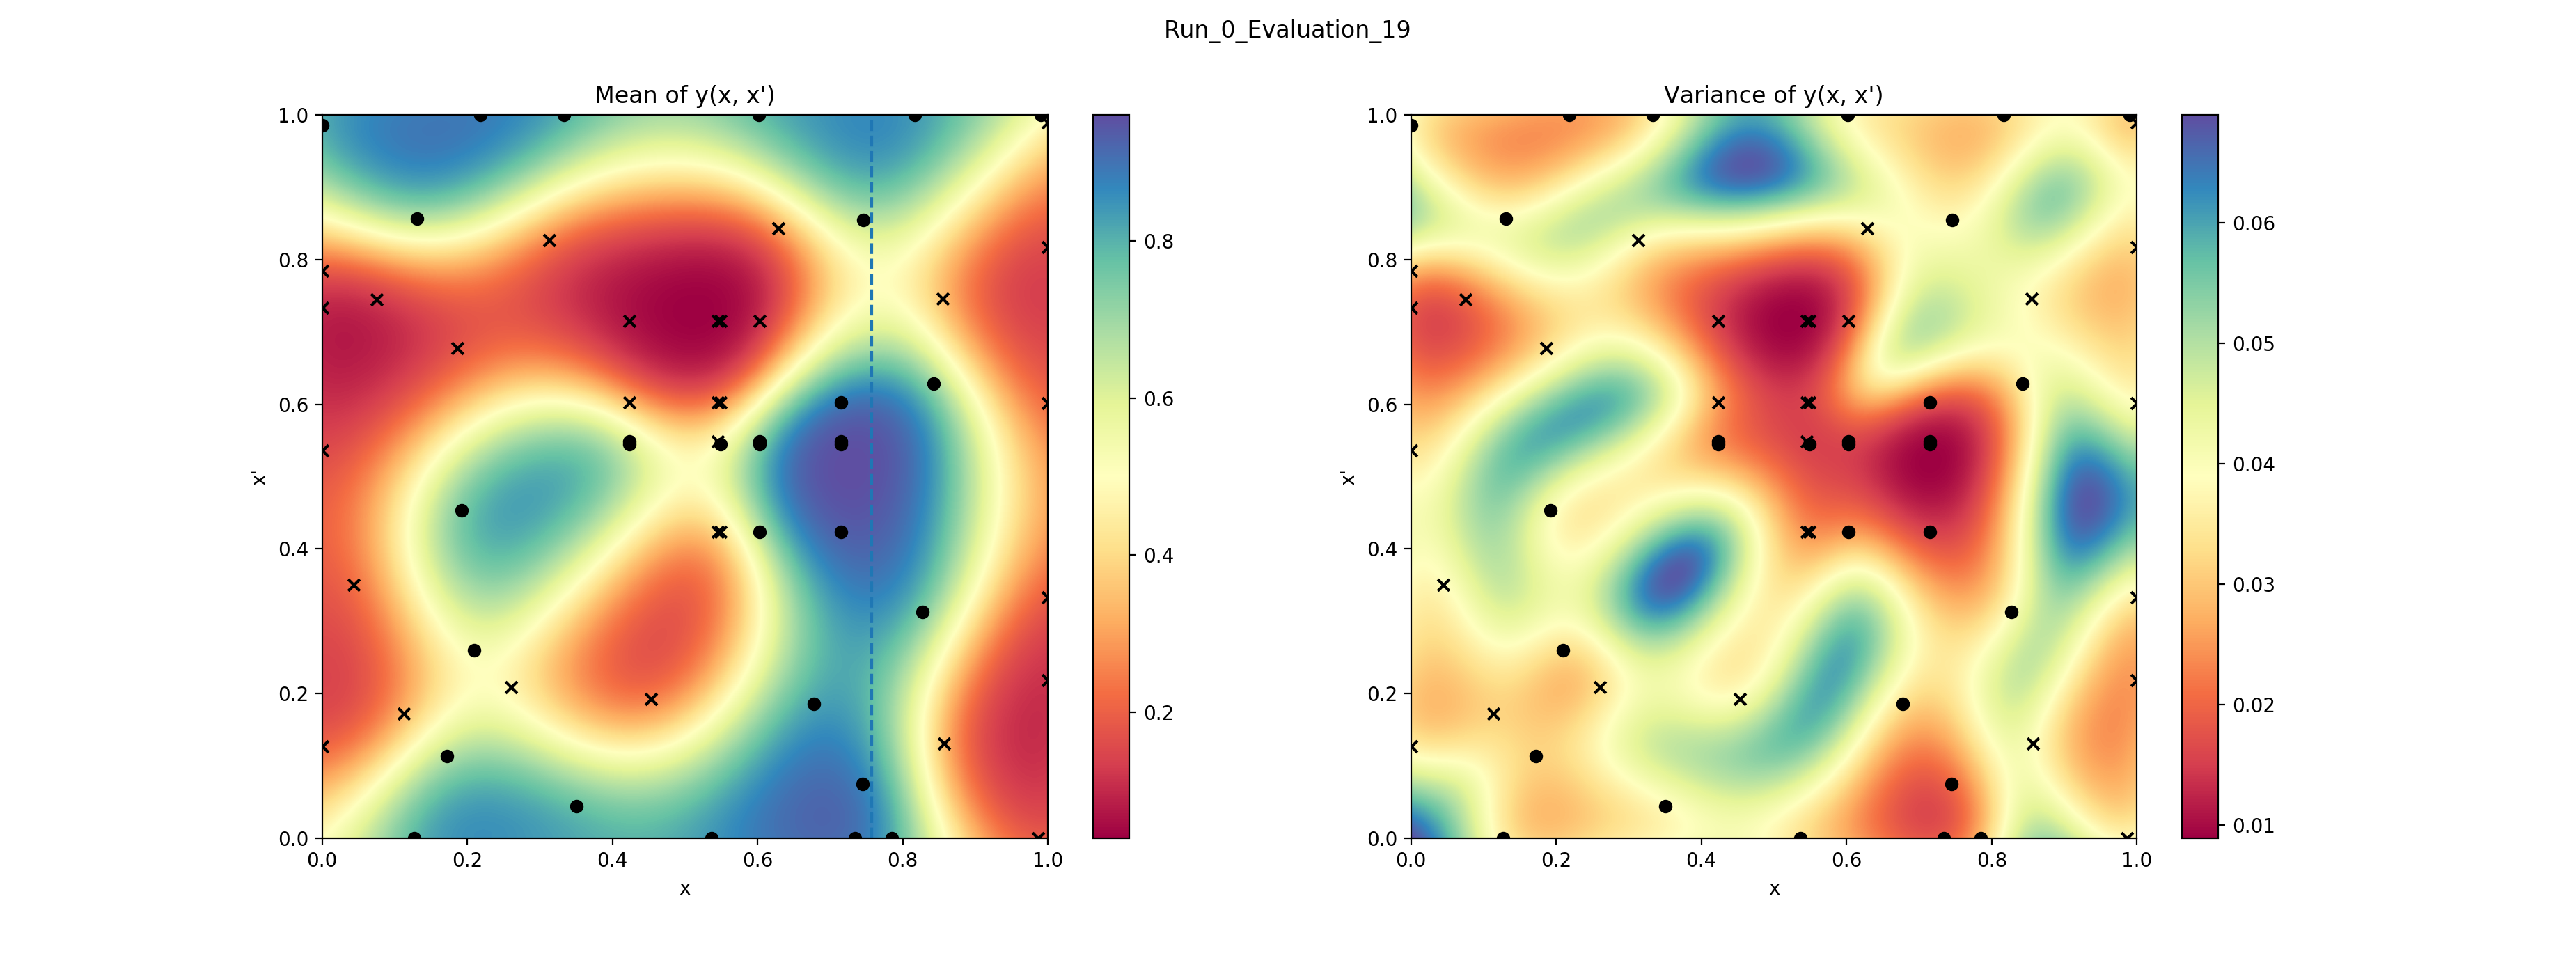

In [12]:
Image("results/PBO_DTS_Run_0_Evaluation_19.png")

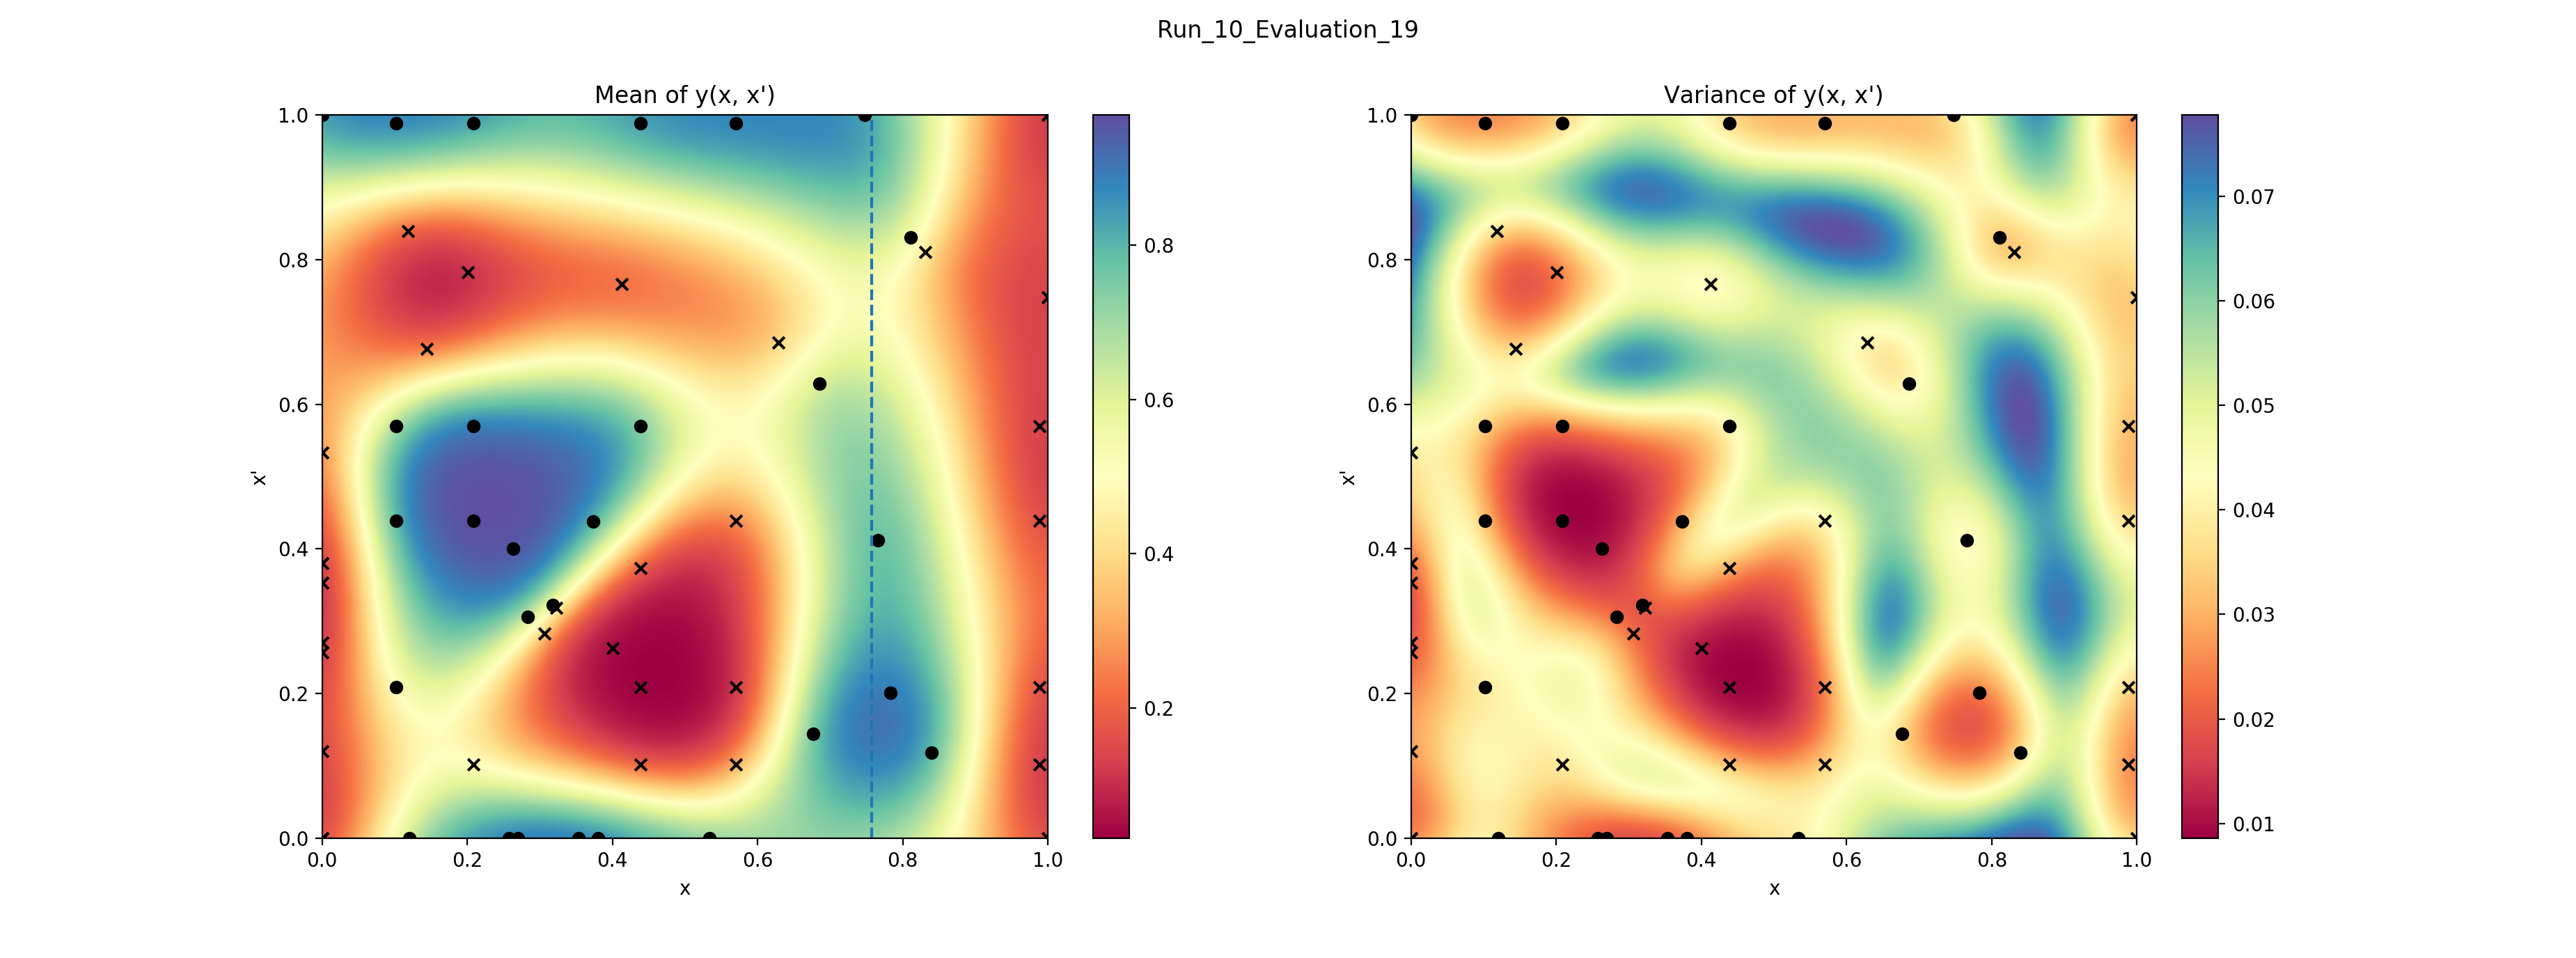

In [13]:
Image("results/PBO_DTS_Run_10_Evaluation_19.png")

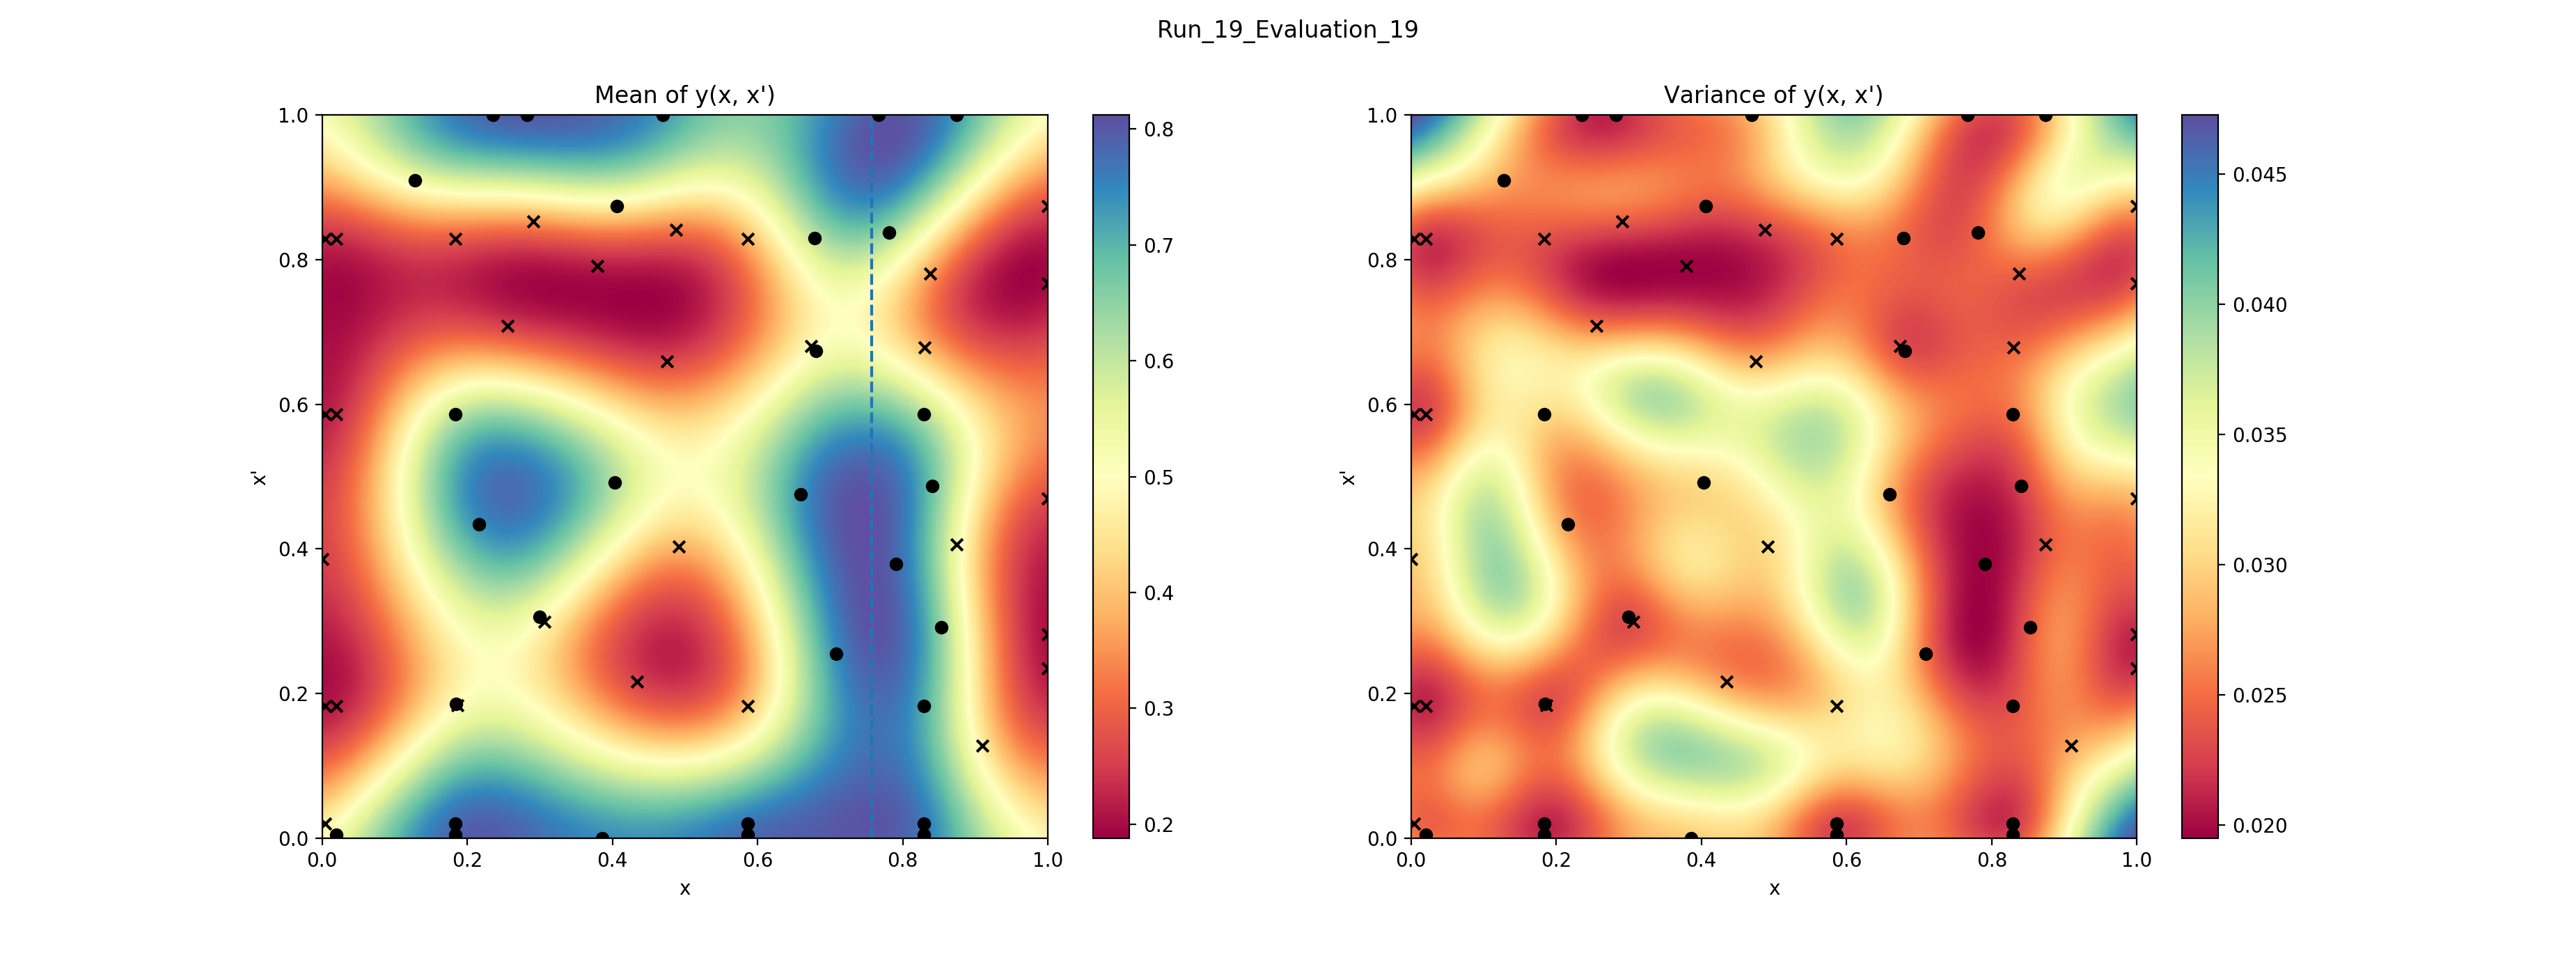

In [14]:
Image("results/PBO_DTS_Run_19_Evaluation_19.png")

### Predictive entropy search

In [15]:
pes_X_results, pes_y_results, pes_best_guess_results = pickle.load( open( "results/PBO_PES_Binary_FullCov_results.p", "rb" ) )

In [16]:
pes_error = abs(np.squeeze(pes_best_guess_results) - global_min)

In [17]:
pes_avg_error = np.mean(pes_error, axis=0)

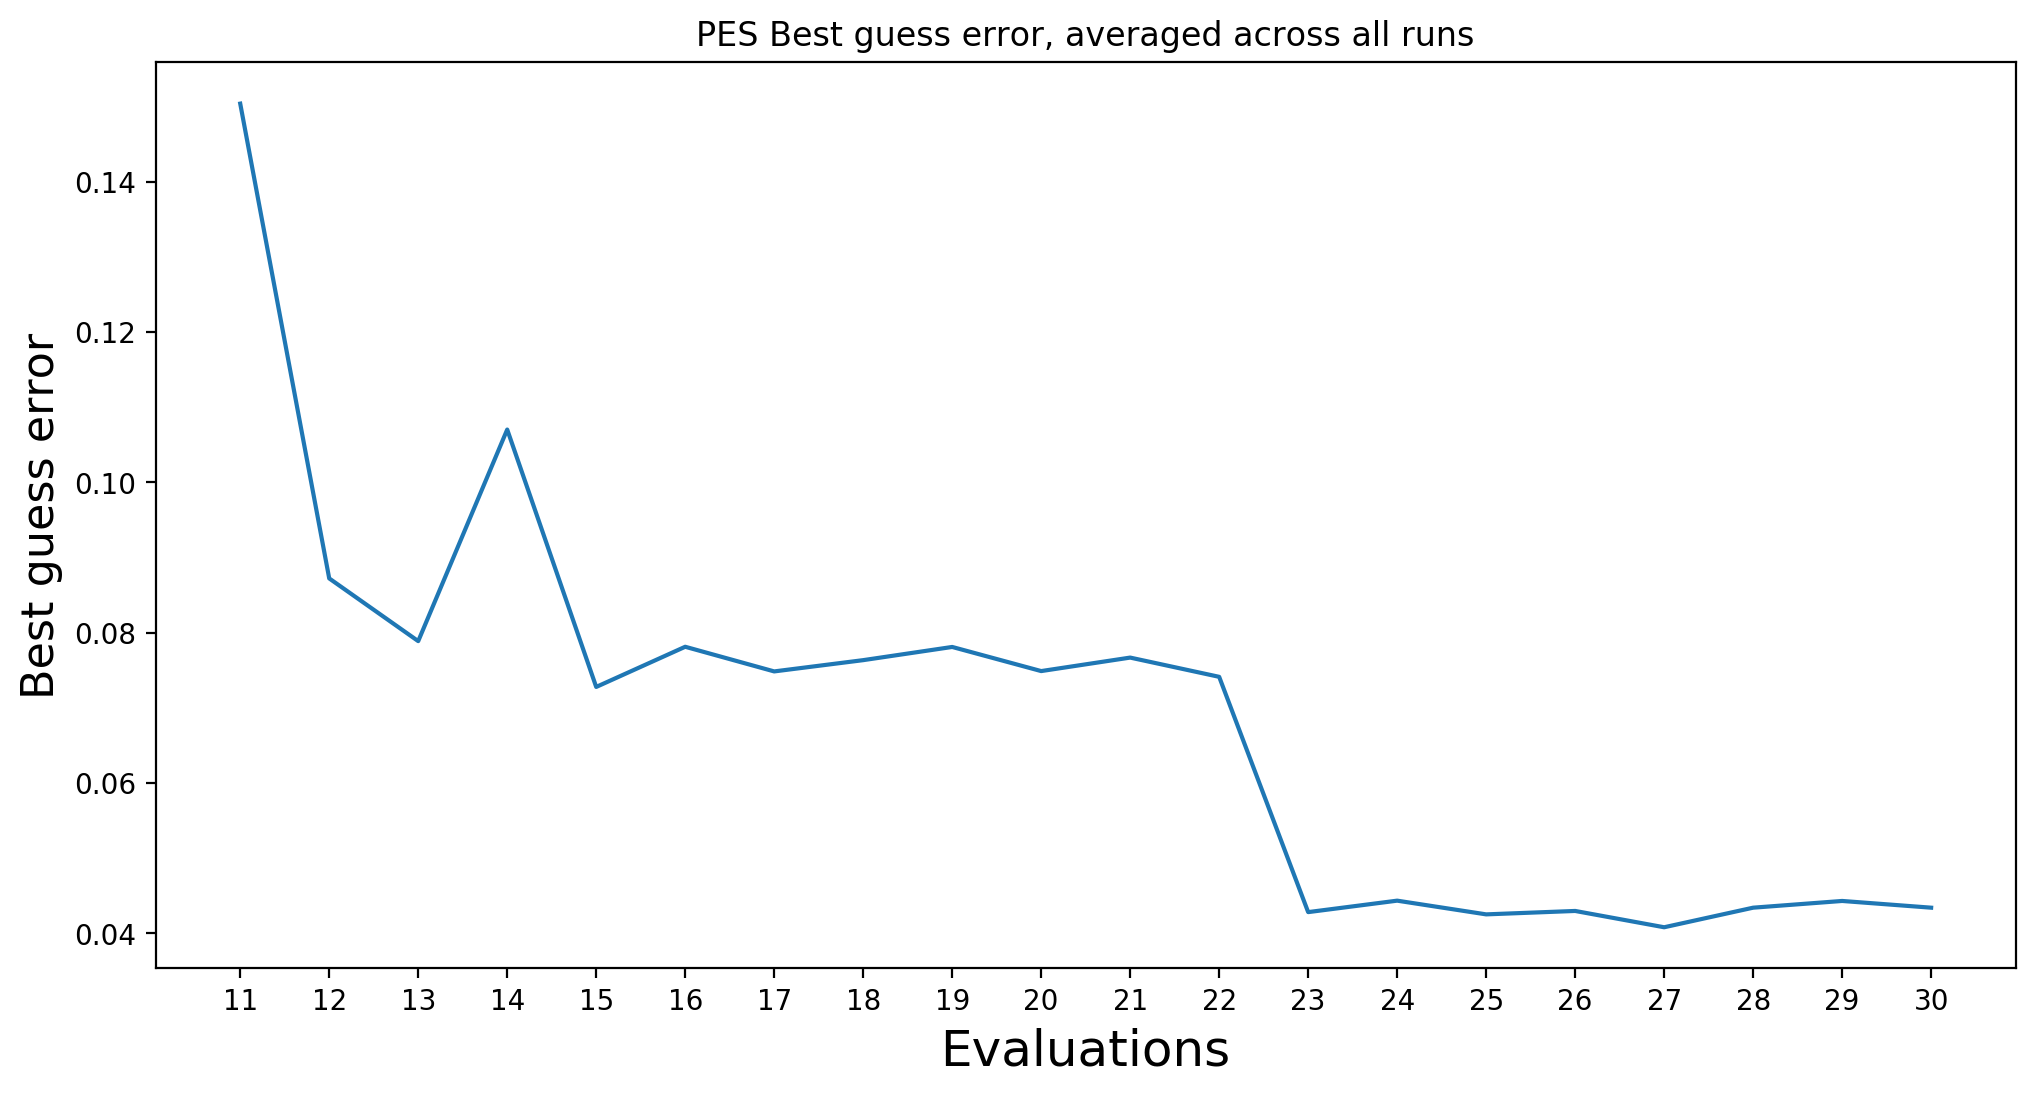

In [48]:
plot_avg_error(pes_avg_error, "PES Best guess error, averaged across all runs")

In [19]:
print("PES absolute best guess error after 30 evaluations: {}".format(pes_avg_error[19]))

PES absolute best guess error after 30 evaluations: 0.04340934093409341


Sample of visualizations of models at final evaluation:

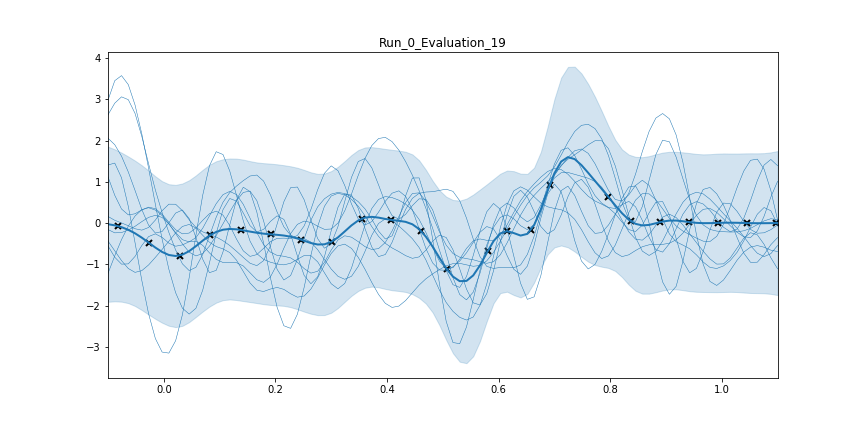

In [49]:
Image("results/PBO_PES_Binary_FullCov_Run_0_Evaluation_19.png")

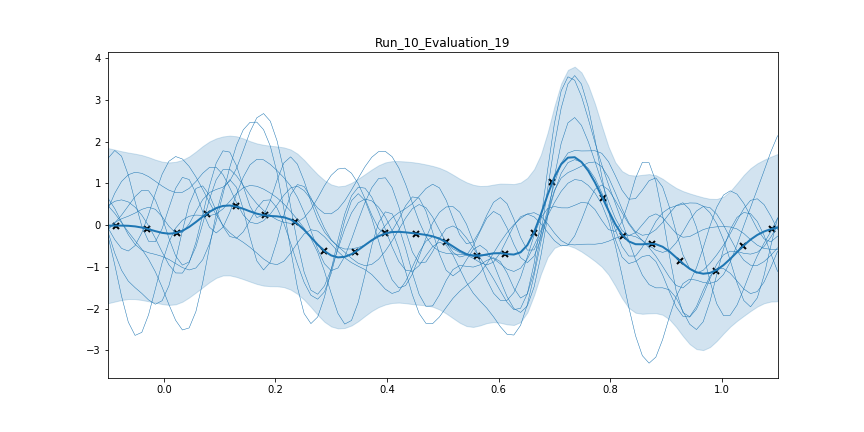

In [21]:
Image("results/PBO_PES_Binary_FullCov_Run_10_Evaluation_19.png")

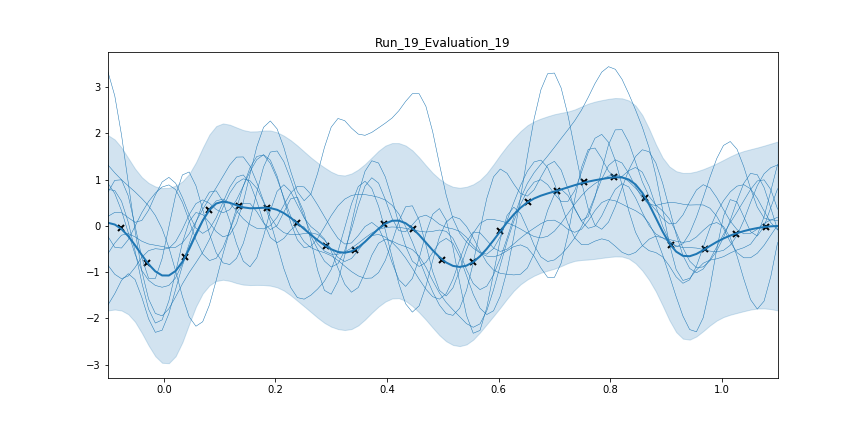

In [22]:
Image("results/PBO_PES_Binary_FullCov_Run_19_Evaluation_19.png")

### Analysis

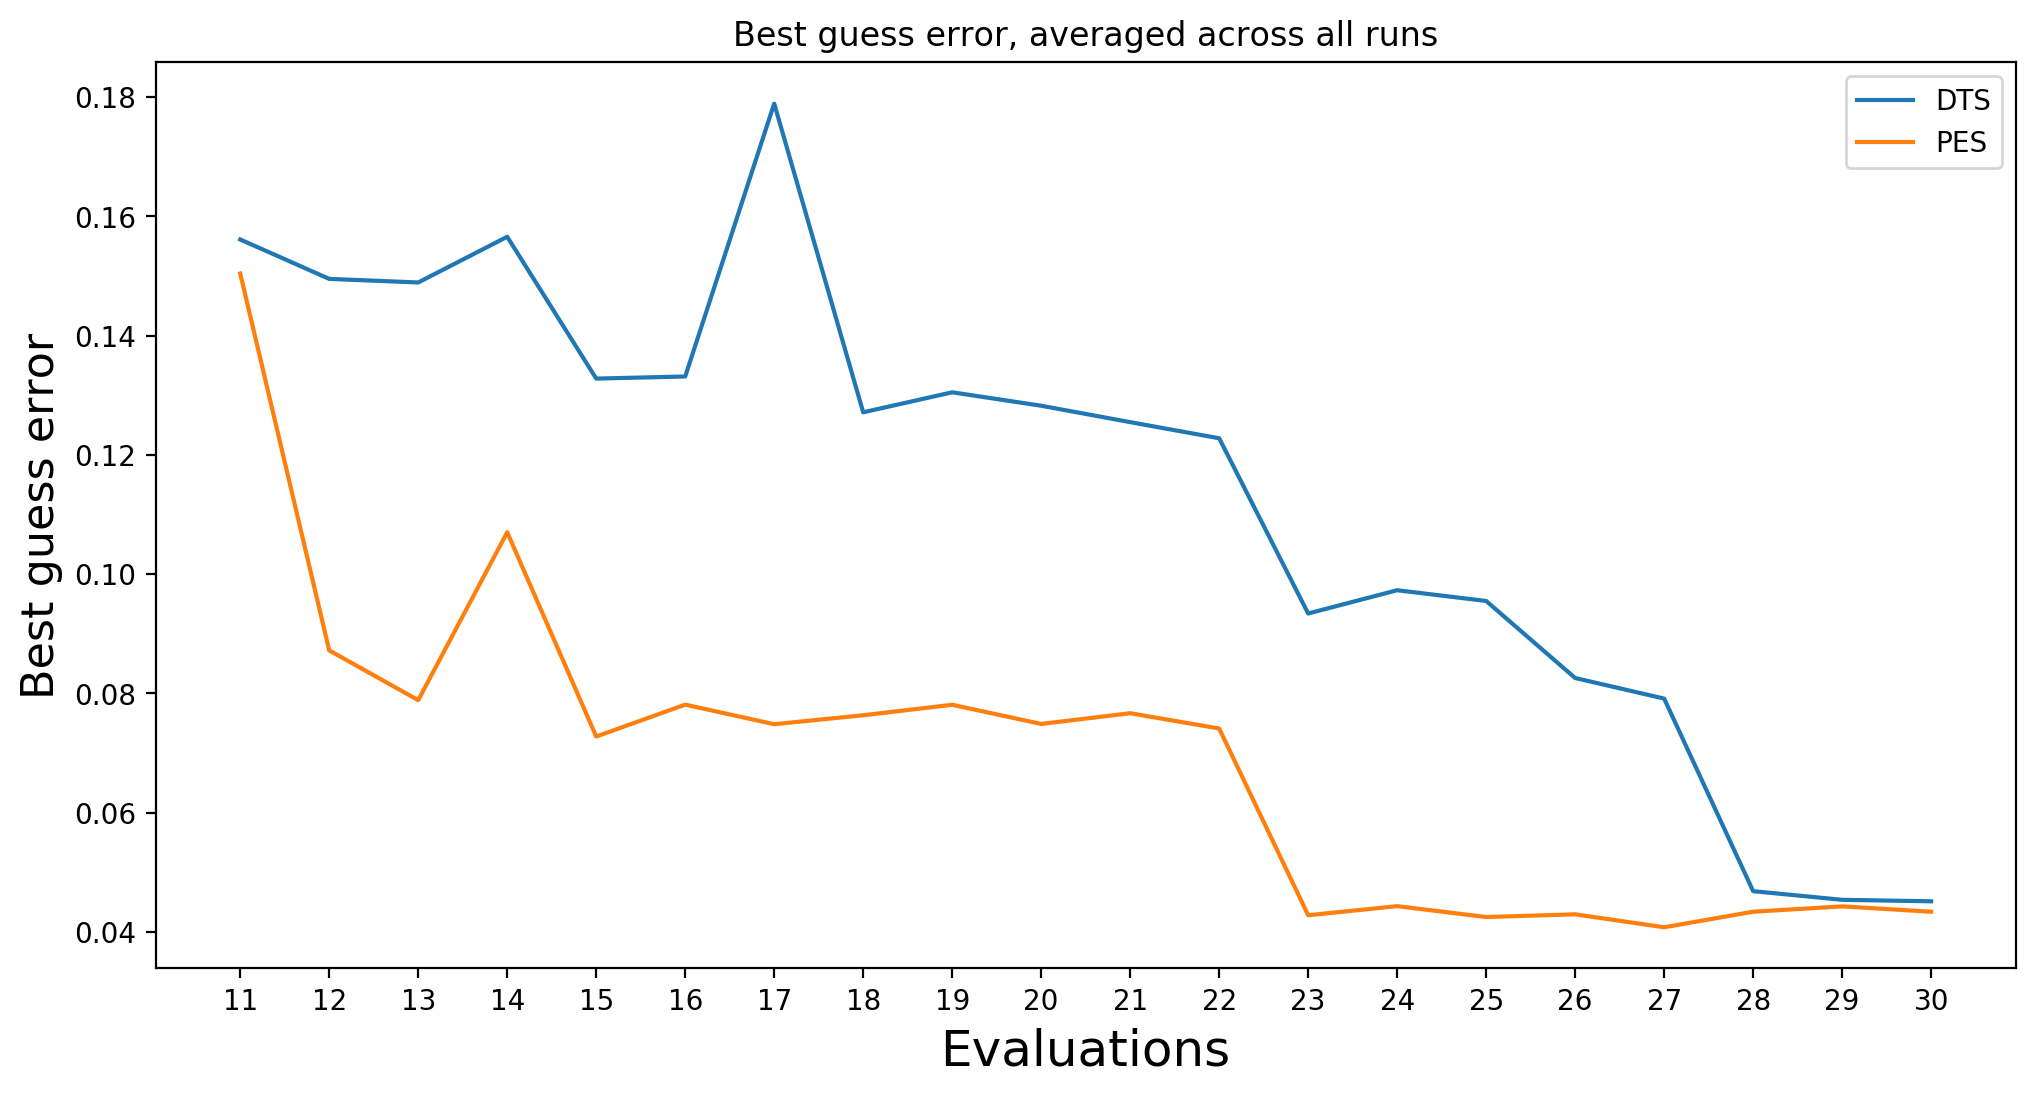

In [50]:
plot_errors([dts_avg_error, pes_avg_error], ["DTS", "PES"], "Best guess error, averaged across all runs")

We observe that while PES and DTS both converge to approximately the same error after 30 evaluations, PES has a lower error with fewer evaluations and is thus more efficient with each evaluation.

The PES formulation also suffers less from the curse of dimensionality, as the DTS formulation of treating the inputs to the model as a concatenation of the 2 query points doubles the number of dimensions which may cause issues with GP models that do not deal well with high dimensional points. In addition, in the DTS formulation, sampling the Condorcet winner requires comparing each discrete point with all other discrete points, leading to O(n^2) comparisons at every query evaluation where n is the number of discrete points in the continuous space, which limits the number of points the space can be discretized into.

The above advantages come at the cost of time efficiency, as the PES experiment took approximately 1 week to run, as compared to the DTS experiment which completed in a few hours. The speed bottleneck is the maximizer sampling procedure, which is a gradient-based optimization step.